### 5. Обучение на неразмеченных данных

- генерация текста
- оценка генерации
- цикл обучения (train loop)

![](images/llm5.1.png)

![](images/llm5.2.png)

### 5.1 Генерация текста (повторение из гл.4 с небольшими изменениями)

![](images/llm5.4.png)

In [1]:
import sys
sys.path.append('code') # добавляем папку с кодом из предыдущей главы
import torch
from chapter_4 import GPTModel 

GPT_CONFIG_124M = {
    "vocab_size": 50257,   
    "context_length": 256, # длина контекста уменьшена в 4 раза для упрощения вычислений
    "emb_dim": 768,        
    "n_heads": 12,         
    "n_layers": 12,       
    "drop_rate": 0.1,      
    "qkv_bias": False      
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Переключение в модель вычислений отключает слои прореживания

In [2]:
import tiktoken
from chapter_4 import generate_text_simple

# упрощенные функции транслящии текста в токен и токена в текст с помощью БПЕ

tokenizer = tiktoken.get_encoding("gpt2")

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

# входящий текст

start_context = "Every effort moves you"

# генерация с помощью модели  

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

# без обучения выдается мусор

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 5.2 Оценка генерации

#### 5.2.1 Метрика качества (loss)

Для изменения весов модели, необходимо количественно измерить отличие целевого выхода (target) и реального (output). Т.к. модель выдает вектор, каждое значение в котором - вероятность (в форме логистического распределения) появления токена соответствующего индекса в словаре, высчитывается "расстояние" между полученными и целевыми распределениями вероятностей - перекрестная энтропия. 

В теории информации перекрёстная энтропия между двумя распределениями вероятностей измеряет среднее число бит, необходимых для опознания события из набора возможностей, если используемая схема кодирования базируется на заданном распределении вероятностей q, вместо «истинного» распределения p. 
Этапы вычисления перекрестной энтропии показаны на рисунке, также они реализованы в стандартной функции pytorch.

Помимо самой перекрестной энтропии, также используется перплексивность - степень неопределенности вероятностной модели, которая вычисляется как экспонента от кросс-энтропии и показывает число возможных токенов словаря примерно одинаковой вероятности. 

![](images/llm5.7.png)

In [3]:
# Задаем вход и цель

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [588,  428,  11311]]) #  " really like chocolate"]

# В режиме без обновления градиентов вычисляем выходы модели

with torch.no_grad():
    logits = model(inputs)

# Применяем логистическую функцию к результатам, полчив вероятности 
# в формате (размер блока, число токенов, размер словаря)

probas = torch.softmax(logits, dim=-1) 
print(probas.shape) 

# Выбираем наиболее вероятный токен

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Идентификаторы токенов :\n", token_ids)

# Выводим преобразованный из токенов текст

print(f"Цели в блоке 1:\n {token_ids_to_text(targets[0], tokenizer)}")
print(f"Выходы в блоке 1:\n {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

target_probas_1 = probas[0, [0, 1, 2], targets[0]]
print("Цели как вероятности в блоке 1:\n", target_probas_1)

target_probas_2 = probas[1, [0, 1, 2], targets[1]]
print("Цели как вероятности в блоке 2:\n", target_probas_2)

# Вычисляем логариф вероятностей

log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

# Вычисляем среднюю вероятность для двух входных блоков

avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

# Умножеаем на -1

neg_avg_log_probas = avg_log_probas * -1
print('Значение метрики ошибки: \n',neg_avg_log_probas)

torch.Size([2, 3, 50257])
Идентификаторы токенов :
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Цели в блоке 1:
  effort moves you
Выходы в блоке 1:
  Armed heNetflix
Цели как вероятности в блоке 1:
 tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Цели как вероятности в блоке 2:
 tensor([3.9836e-05, 1.6783e-05, 4.7559e-06])
tensor([ -9.5042, -10.3796, -11.3677, -10.1307, -10.9951, -12.2561])
tensor(-10.7722)
Значение метрики ошибки: 
 tensor(10.7722)


In [4]:

print("Размерность выхода: \n", logits.shape)
print("Размерность целей: \n", targets.shape)

# Для подчета перекрестной энтропии, изменим форму матриц, совместив их вдоль блоков (over the batch dimension)

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Размерность совмещенного выхода: \n", logits_flat.shape)
print("Размерность совмещенных целей: \n", targets_flat.shape)

# Вычисление значения ошибки с помощью стандартной функции (совпадает с полученным выше)

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print('Значение ошибки: \n', loss)

perplexity = torch.exp(loss)
print('Перплексия: \n', perplexity)

Размерность выхода: 
 torch.Size([2, 3, 50257])
Размерность целей: 
 torch.Size([2, 3])
Размерность совмещенного выхода: 
 torch.Size([6, 50257])
Размерность совмещенных целей: 
 torch.Size([6])
Значение ошибки: 
 tensor(10.7722)
Перплексия: 
 tensor(47678.8633)


#### 5.2.2 Вычисление метрики на наборе для обучения и тестирования 

![](images/llm5.10.png)

In [5]:
import os
import urllib.request

# Прочитаем текстовый файл

file_path = "source/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

# Разделим прочитанный текст на набор для обучения и проверки
    
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# Создадим загрузчики данных для обучающего и проверочного набора

from chapter_4 import create_dataloader_v1

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

# Функция вычисления ошибки для батча данных

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

# Функция вычисления ошибки, встроенная в загрузчик данных 

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

# Зададим вычислительные ресурсы 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 

# Вычислим ошибку в режиме без обновления весов

with torch.no_grad(): 
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Ошибка на наборе обучения: \n", train_loss)
print("Ошибка на наборе тестирования: \n", val_loss)

Ошибка на наборе обучения: 
 10.987583690219456
Ошибка на наборе тестирования: 
 10.98110580444336


### 5.3 Цикл обучения

![](images/llm5.12.png)

In [6]:
# Зададим цикл обучения

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Переменные для сохранения значений
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Главный цикл
    for epoch in range(num_epochs):
        # Режим обучения
        model.train() 
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Очистка градиентов от предыдущего цикла
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Вычисление градиентов
            optimizer.step() # Обновление весов
            tokens_seen += input_batch.numel()
            global_step += 1

            # Обновление промежуточных значений обучения
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Печать экземпляра текста
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  
    model.train()

In [7]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.819, Val loss 9.925
Ep 1 (Step 000005): Train loss 8.067, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.623, Val loss 7.051
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.602
Every effort moves you, and,, and,, and,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.574, Val loss 6.488
Ep 3 (Step 000025): Train loss 5.500, Val loss 6.400
Every effort moves you, and, and, and, and, and, and, and. G. Gis, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 5.086, Val loss 6.328
Ep 4 (Step 000035): Train loss 4.857, Val loss 6.333
Every effort moves you, and a. Gisburn, and a, and a.              "I"--as Jack a of the of the of the of the picture"I had been the of
Ep 5 (Step 000040): Train loss 4.313, Val loss 6.252
Every effort moves you, I felt, and I felt--I had the fact a little of the honour of th

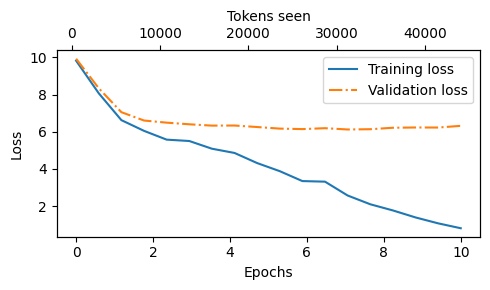

In [8]:
# Графическая иллюстрация динамики обучения
# Кривая тестового набора не снижает значение ошибки после второй эпохи, 
# а кривая обучающего набора снижает. Т.е. наблиюдается ошибка переобучения.

import matplotlib.pyplot as plt

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))


    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")


    ax2 = ax1.twiny()  
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout() 
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### 5.4 Приемы улучшения выходных значений

Т.к. для предсказания выбирается наиболее вероятный токен из выхода модели, все остальные как правило не учитываются. Хотя в близи наиболее вероятного токена могут быть также корректные значения. 